#### John Peterson (February Cohort) 2-27-18

#### Springboard Data Science Career Track - Capstone Project 1


In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data file downloaded 02-27-18
# This will be the file used, data is from 11/1/15 to 2/20/18

# Assign filename
data_022718 = 'crime-datacrime-datacrimestat.csv'

# Read file in DataFrame
# ZIP as dtype object to remove decimal point
crime = pd.read_csv(data_022718, sep=',', low_memory=False, dtype={'ZIP': object})

# Quick view of the data
print(crime.head())
print(crime.info())

# Rename columns
crime.columns = ['incident_num', 'date_occurred_on', 'date_occurred_to', 'crime_cat', '100_block_addr', 'zip', 'premise_type']


        INC NUMBER        OCCURRED ON        OCCURRED TO   UCR CRIME CATEGORY  \
0  201600000052855  11/01/2015  00:00  01/09/2016  00:00  MOTOR VEHICLE THEFT   
1  201600000594484  11/01/2015  00:00                NaN                 RAPE   
2  201500002102327  11/01/2015  00:00  11/01/2015  09:00        LARCENY-THEFT   
3  201500002101405  11/01/2015  00:00  11/01/2015  05:00  MOTOR VEHICLE THEFT   
4  201500002102668  11/01/2015  00:00  11/01/2015  11:50  MOTOR VEHICLE THEFT   

             100 BLOCK ADDR    ZIP         PREMISE TYPE  
0  N 43RD AVE & W CACTUS RD  85029  SINGLE FAMILY HOUSE  
1         13XX E ALMERIA RD  85006  SINGLE FAMILY HOUSE  
2            51XX N 15TH ST  85014            APARTMENT  
3       102XX W MEDLOCK AVE  85307  SINGLE FAMILY HOUSE  
4            69XX W WOOD ST  85043  SINGLE FAMILY HOUSE  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148468 entries, 0 to 148467
Data columns (total 7 columns):
INC NUMBER            148468 non-null object
OCCURRED O

## Data Wrangling

In [2]:
# 4 variables have missing data: Occurred On, Occurred To, Zip, Premise Type
print(crime[['date_occurred_on', 'date_occurred_to', 'zip', 'premise_type']].isna().sum())
# 'date_occurred_to' field is blank because the victim knows the exact time the incident occurred and only the 'date_occurred_on' is populated

# Sum number of incidents where occurred_on and occurred_to are NaN
print(crime[(crime.date_occurred_on.isna()) & (crime.date_occurred_to.isna())])


#print(crime.loc[crime['zip'].isna()])
#print(crime.loc[crime['date_occurred_on'].isna()].head())
#print(crime.loc[crime['date_occurred_to'].isna()].head())
#print(crime.loc[crime['premise_type'].isna()].head())

date_occurred_on      336
date_occurred_to    43719
zip                     3
premise_type          805
dtype: int64
Empty DataFrame
Columns: [incident_num, date_occurred_on, date_occurred_to, crime_cat, 100_block_addr, zip, premise_type]
Index: []


In [3]:
# Identify the unique values
print(crime[['crime_cat', 'zip', 'premise_type']].nunique())
#print(crime.crime_cat.unique())
#print(crime.zip.unique())
#print(crime.premise_type.unique())

crime_cat        9
zip             99
premise_type    94
dtype: int64


In [4]:
# Cleaning the data set

# Remove missing zip code rows and convert to str
crime_clean = crime.drop(crime.index[[63037, 79708, 82276]])
#print(crime_clean.loc[crime_clean['zip'].isna()])

# Fill in missing date values with date_occurred_on or date_occurred_to
crime_clean.date_occurred_on.fillna(crime_clean.date_occurred_to, inplace=True)
#print(crime_clean.iloc[248])
crime_clean.date_occurred_to.fillna(crime_clean.date_occurred_on, inplace=True)
#print(crime_clean.iloc[24])
#print(crime_clean[['date_occurred_on', 'date_occurred_to']].isna().sum())

# Premise type NaN convert to Unknown
crime_clean.premise_type = crime_clean.premise_type.fillna('UNKNOWN')

# Combine 'STREET / ROADWAY / ALLEY / SIDEWALK' and 'STREET / ROADWAY / ALLEY SIDEWALK'
crime_clean.loc[crime_clean['premise_type'] == 'STREET / ROADWAY / ALLEY SIDEWALK'] = crime_clean.loc[crime_clean['premise_type'] == 'STREET / ROADWAY / ALLEY SIDEWALK'].replace('STREET / ROADWAY / ALLEY SIDEWALK', 'STREET / ROADWAY / ALLEY / SIDEWALK')


In [5]:
# Convert date columns to datetime
crime_clean['date_occurred_on'] = pd.to_datetime(crime_clean['date_occurred_on'], format='%m/%d/%Y %H:%M')
crime_clean['date_occurred_to'] = pd.to_datetime(crime_clean['date_occurred_to'], format='%m/%d/%Y %H:%M')
#crime_clean.info()

# Break down datetime columns into seperate columns, new columns listed below
# date_occ_on ==> [occ_on_month, occ_on_day, occ_on_year, occ_on_hr, occ_on_min]
crime_clean['occ_on_month'] = crime_clean['date_occurred_on'].dt.month
crime_clean['occ_on_day'] = crime_clean['date_occurred_on'].dt.day
crime_clean['occ_on_year'] = crime_clean['date_occurred_on'].dt.year
crime_clean['occ_on_dayofweek'] = crime_clean['date_occurred_on'].dt.weekday_name
crime_clean['occ_on_time'] = crime_clean['date_occurred_on'].dt.time
crime_clean['occ_on_hr'] = crime_clean['date_occurred_on'].dt.hour
crime_clean['occ_on_min'] = crime_clean['date_occurred_on'].dt.minute

# date_occ_to ==> [occ_to_month, occ_to_day, occ_to_year, occ_to_hr, occ_to_min]
crime_clean['occ_to_month'] = crime_clean['date_occurred_to'].dt.month
crime_clean['occ_to_day'] = crime_clean['date_occurred_to'].dt.day
crime_clean['occ_to_year'] = crime_clean['date_occurred_to'].dt.year
crime_clean['occ_to_dayofweek'] = crime_clean['date_occurred_to'].dt.weekday_name
crime_clean['occ_to_time'] = crime_clean['date_occurred_to'].dt.time
crime_clean['occ_to_hr'] = crime_clean['date_occurred_to'].dt.hour
crime_clean['occ_to_min'] = crime_clean['date_occurred_to'].dt.minute

#crime_clean.head()
#crime_clean.info()


In [6]:
# Classify incident times into 4hr bucket groups
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
occ_on_hr_grp = []
for row in crime_clean.occ_on_hr:
    if row in [0,1,2,3]:
        occ_on_hr_grp.append('A')
    elif row in [4,5,6,7]:
        occ_on_hr_grp.append('B')
    elif row in [8,9,10,11]:
        occ_on_hr_grp.append('C')
    elif row in [12,13,14,15]:
        occ_on_hr_grp.append('D')
    elif row in [16,17,18,19]:
        occ_on_hr_grp.append('E')
    else: 
        occ_on_hr_grp.append('F')
    
crime_clean['occ_on_hr_grp'] = occ_on_hr_grp


In [7]:
# Classify incident months into seasons
# Spring(3,4,5), Summer(6,7,8), Fall(9,10,11), Winter(12,1,2)
occ_on_season = []
for row in crime_clean.occ_on_month:
    if row in [3,4,5]:
        occ_on_season.append('Spring')
    elif row in [6,7,8]:
        occ_on_season.append('Summer')
    elif row in [9,10,11]:
        occ_on_season.append('Fall')
    else:
        occ_on_season.append('Winter')
        
crime_clean['occ_on_season'] = occ_on_season

# crime_clean is the clean data set

## Exploratory Data Analysis

**Initial Questions**

 1. What are the top tredning crimes?
 2. When do crimes occur: Month, Day, Year, Season?
 3. Do more crimes occur in certain zip codes?
 4. What is the most common place a crime occurs e.g. house, business, etc.?

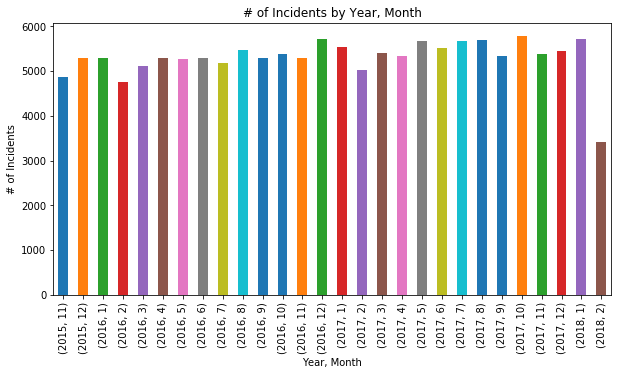

In [16]:
# Number of incidents per month by year
inc_mon_yr = crime_clean.groupby(['occ_on_year', 'occ_on_month'])['incident_num'].count()
inc_mon_yr
inc_mon_yr.plot(kind='bar', figsize=(10,5))
plt.ylabel('# of Incidents')
plt.xlabel('Year, Month')
plt.title('# of Incidents by Year, Month')
plt.show()

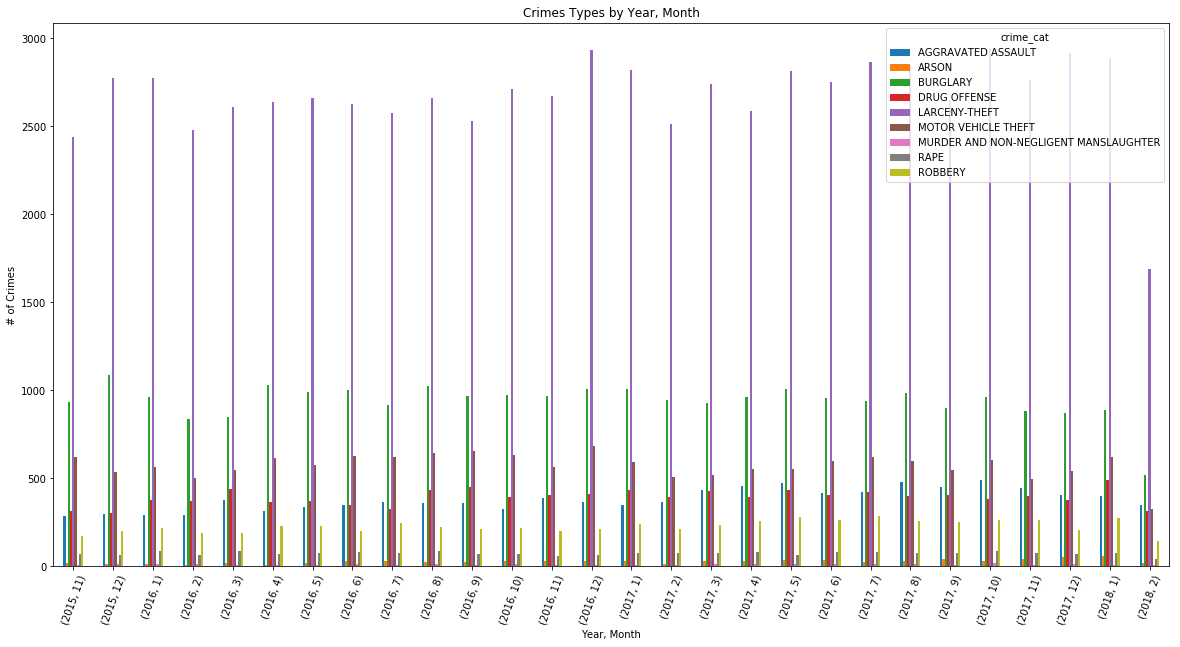

In [9]:
# Number of types of crime per month by year
crime_month = crime_clean.groupby(['occ_on_year','occ_on_month','crime_cat'])['crime_cat'].count()
crime_month.unstack().plot(kind='bar', figsize=(20,10), rot=70)
plt.title('Crimes Types by Year, Month')
plt.xlabel('Year, Month')
plt.ylabel('# of Crimes')
plt.show()

occ_on_dayofweek
Friday       22600
Wednesday    21864
Tuesday      21774
Thursday     21615
Monday       21217
Saturday     20468
Sunday       18927
Name: incident_num, dtype: int64


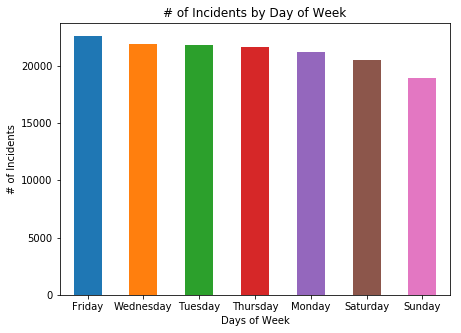

In [10]:
# Day of the week crimes take place
crime_dayofweek = crime_clean.groupby('occ_on_dayofweek')['incident_num'].count().sort_values(ascending=False)
print(crime_dayofweek)
crime_dayofweek.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by Day of Week')
plt.ylabel('# of Incidents')
plt.xlabel('Days of Week')
plt.show()

occ_on_hr_grp
E    33717
D    29432
F    29193
C    22367
A    20489
B    13267
Name: incident_num, dtype: int64


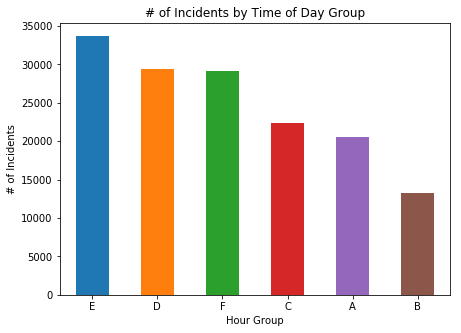

In [11]:
# Time of Day crimes occur
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
crime_timeofday = crime_clean.groupby('occ_on_hr_grp')['incident_num'].count().sort_values(ascending=False)
print(crime_timeofday[:10])
crime_timeofday.plot(kind='bar', figsize=(7,5), rot=0,)
plt.title('# of Incidents by Time of Day Group')
plt.xlabel('Hour Group')
plt.ylabel('# of Incidents')
plt.show()

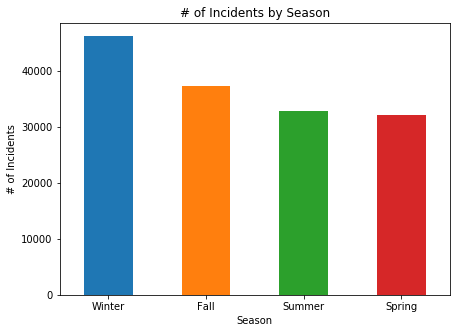

In [12]:
# Time of year most crimes occurred
season_inc = crime_clean.groupby('occ_on_season')['incident_num'].count().sort_values(ascending=False)
season_inc
season_inc.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by Season')
plt.xlabel('Season')
plt.ylabel('# of Incidents')
plt.show()

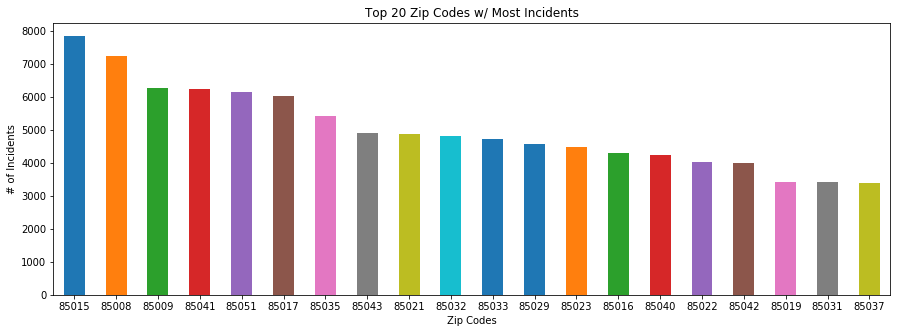

In [13]:
# Crimes by zip code
zip_inc = crime_clean.groupby('zip')['incident_num'].count().sort_values(ascending=False)
zip_inc
zip_inc[0:20].plot(kind='bar', figsize=(15,5), rot=0)
plt.title('Top 20 Zip Codes w/ Most Incidents')
plt.xlabel('Zip Codes')
plt.ylabel('# of Incidents')
plt.show()

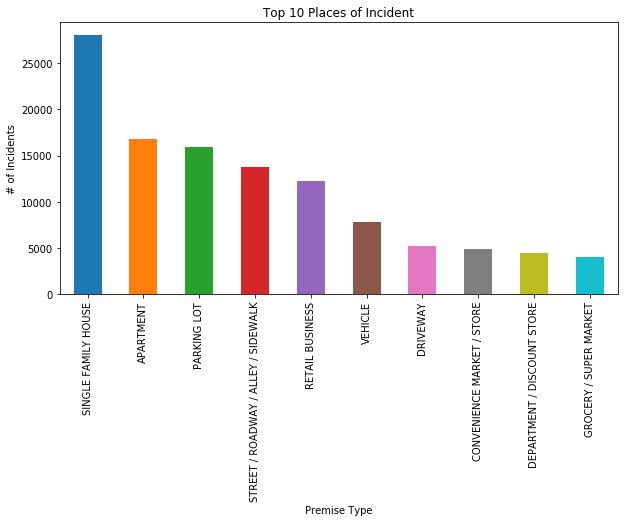

In [14]:
# Most common place a crime takes place
premise_count = crime_clean.groupby('premise_type')['incident_num'].count().sort_values(ascending=False)
premise_count
premise_count[0:10].plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Places of Incident')
plt.xlabel('Premise Type')
plt.ylabel('# of Incidents')
plt.show()

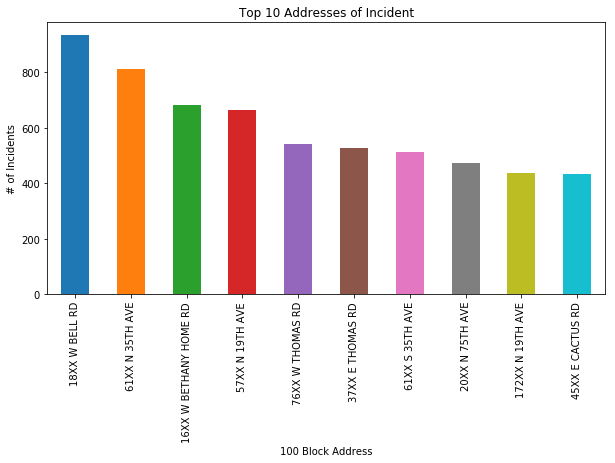

In [35]:
# Crimes by 100 block addr
block_count = crime_clean.groupby('100_block_addr')['incident_num'].count().sort_values(ascending=False)
block_count[0:10].plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Addresses of Incident')
plt.xlabel('100 Block Address')
plt.ylabel('# of Incidents')
plt.show()

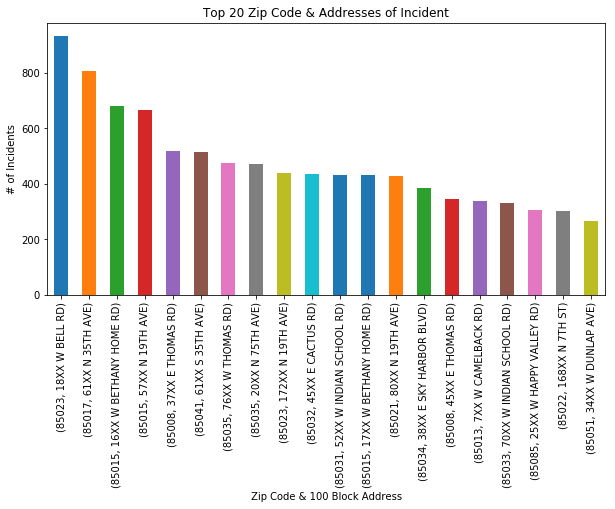

In [38]:
# Crimes by 100 block addr and zip
zip_block_count = crime_clean.groupby(['zip','100_block_addr'])['incident_num'].count().sort_values(ascending=False)
zip_block_count[0:20].plot(kind='bar', figsize=(10,5))
plt.title('Top 20 Zip Code & Addresses of Incident')
plt.xlabel('Zip Code & 100 Block Address')
plt.ylabel('# of Incidents')
plt.show()

**Market Basket Analysis**

In [19]:
# Create basket df
basket = crime_clean[['crime_cat', 'zip', 'premise_type', 'occ_on_month', 'occ_on_day', 'occ_on_year', 'occ_on_hr_grp', 'occ_on_dayofweek', 'occ_on_season']]
basket = pd.DataFrame(basket)
#basket.info()

In [20]:
# change int to string
basket['occ_on_month'] = basket['occ_on_month'].astype(str)
basket['occ_on_day'] = basket['occ_on_day'].astype(str)
basket['occ_on_year'] = basket['occ_on_year'].astype(str)

In [21]:
# change month number to string (e.g Jan, Feb, etc.)
basket.loc[basket['occ_on_month'] == '1'] = basket.loc[basket['occ_on_month'] == '1'].replace('1', 'Jan')
basket.loc[basket['occ_on_month'] == '2'] = basket.loc[basket['occ_on_month'] == '2'].replace('2', 'Feb')
basket.loc[basket['occ_on_month'] == '3'] = basket.loc[basket['occ_on_month'] == '3'].replace('3', 'Mar')
basket.loc[basket['occ_on_month'] == '4'] = basket.loc[basket['occ_on_month'] == '4'].replace('4', 'Apr')
basket.loc[basket['occ_on_month'] == '5'] = basket.loc[basket['occ_on_month'] == '5'].replace('5', 'May')
basket.loc[basket['occ_on_month'] == '6'] = basket.loc[basket['occ_on_month'] == '6'].replace('6', 'Jun')
basket.loc[basket['occ_on_month'] == '7'] = basket.loc[basket['occ_on_month'] == '7'].replace('7', 'Jul')
basket.loc[basket['occ_on_month'] == '8'] = basket.loc[basket['occ_on_month'] == '8'].replace('8', 'Aug')
basket.loc[basket['occ_on_month'] == '9'] = basket.loc[basket['occ_on_month'] == '9'].replace('9', 'Sep')
basket.loc[basket['occ_on_month'] == '10'] = basket.loc[basket['occ_on_month'] == '10'].replace('10', 'Oct')
basket.loc[basket['occ_on_month'] == '11'] = basket.loc[basket['occ_on_month'] == '11'].replace('11', 'Nov')
basket.loc[basket['occ_on_month'] == '12'] = basket.loc[basket['occ_on_month'] == '12'].replace('12', 'Dec')

In [22]:
# create different baskets with different items

# basket 1: crime cat, zip
basket_1 = np.array(basket[['crime_cat', 'zip']])

# basket 2: crime cat, time of day, day of the week
basket_2 = np.array(basket[['crime_cat', 'occ_on_hr_grp', 'occ_on_dayofweek']])

# basket 3: crime_cat, month, day, year
basket_3 = np.array(basket[['crime_cat', 'occ_on_month', 'occ_on_day', 'occ_on_year']])

# basket 4: crime cat, season
basket_4 = np.array(basket[['crime_cat', 'occ_on_season']])

# basket 5: crime cat, zip, premise type
basket_5 = np.array(basket[['crime_cat', 'zip', 'premise_type']])


In [23]:
# train apriori model
from apyori import apriori

rules_1 = apriori(basket_1, min_support=0.003, min_confidence=0.2)
rules_2 = apriori(basket_2, min_support=0.05, min_confidence=0.2)
rules_3 = apriori(basket_3, min_support=0.05, min_confidence=0.2)
rules_4 = apriori(basket_4, min_support=0.05, min_confidence=0.2)
rules_5 = apriori(basket_5, min_support=0.003, min_confidence=0.2)

In [13]:
# results rules 1
results_1 = list(rules_1)
#results_1

In [14]:
# results rules 2
results_2 = list(rules_2)
#results_2

In [15]:
# results rules 3
results_3 = list(rules_3)
#results_3

In [16]:
# results rules 4
results_4 = list(rules_4)
#results_4

In [17]:
# results rules  5
results_5 = list(rules_5)
#results_5

**Inferential Statistics**

In [24]:
import scipy.stats as stats

# describe the basket
basket.describe()

,crime_cat,zip,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_hr_grp,occ_on_dayofweek,occ_on_season
count,148465,148465,148465,148465,148465,148465,148465,148465,148465
unique,9,99,93,12,43,4,6,7,4
top,LARCENY-THEFT,85015,SINGLE FAMILY HOUSE,Jan,1,2017,E,Friday,Winter
freq,74883,7839,28011,16565,5177,65844,33717,22600,46223


**1. Compare Crime Category with Zip Code**

  * **Null Hypothesis:** There is no association between the crime type and zip code.
  * **Alternate Hypothesis:** There is an association between the crime type and zip code.

In [49]:
# use contingency table and chi-square to test association
con_table = pd.crosstab(index=basket.crime_cat, columns=basket.zip)
con_table

zip,85003,85004,85006,85007,85008,85009,85012,85013,85014,85015,...,85345,85353,85355,85363,85381,85382,85383,85392,85395,85396
crime_cat,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED ASSAULT,139,138,281,276,592,559,47,181,162,539,...,0,122,0,0,0,0,1,2,1,0
ARSON,8,4,27,25,60,28,3,10,11,59,...,0,6,0,0,0,0,0,0,0,0
BURGLARY,205,167,527,331,1059,1056,166,546,528,1257,...,0,365,0,0,0,0,1,0,0,1
DRUG OFFENSE,223,126,220,320,560,748,78,223,163,661,...,4,35,1,0,1,0,1,7,0,1
LARCENY-THEFT,857,1124,1353,857,3665,2444,527,1809,1314,4125,...,0,667,0,0,0,1,0,0,0,3
MOTOR VEHICLE THEFT,134,146,322,197,843,981,61,250,206,638,...,1,216,0,0,0,1,1,0,0,4
MURDER AND NON-NEGLIGENT MANSLAUGHTER,1,5,15,14,19,15,2,1,7,22,...,0,6,0,0,0,0,0,0,0,0
RAPE,48,40,88,72,108,84,17,62,60,86,...,1,14,0,1,0,0,0,0,1,0
ROBBERY,90,105,170,143,314,349,40,148,97,452,...,1,62,0,0,0,0,0,0,0,1


In [66]:
# contingecy table with percentages
con_table_percent = pd.crosstab(index=basket.crime_cat, columns=basket.zip).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent

In [51]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 8401.536479555802) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and the zip code.

**2. Compare Crime Category with Time Crime Occurred**

  * **Null Hypothesis:** There is no association between the crime type and time of day crime occurred.
  * **Alternate Hypothesis:** There is an association between crime type and time of day crime occurred.

In [52]:
# contignecy table crime type and time of day
con_table_1 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_hr_grp)
con_table_1

occ_on_hr_grp,A,B,C,D,E,F
crime_cat,,,,,,
AGGRAVATED ASSAULT,1879,749,1167,1845,2506,2506
ARSON,159,106,120,114,141,147
BURGLARY,3407,4029,5602,4964,4881,3404
DRUG OFFENSE,1529,766,1686,2110,2736,2162
LARCENY-THEFT,9049,5144,10894,16814,18719,14263
MOTOR VEHICLE THEFT,2506,1718,2029,2242,3046,4537
MURDER AND NON-NEGLIGENT MANSLAUGHTER,90,37,23,40,52,78
RAPE,697,139,187,264,330,462
ROBBERY,1173,579,659,1039,1306,1634


In [67]:
# contingency table with percentages
con_table_percent_1 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_hr_grp).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_1

In [116]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_1)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 6545.711432337271) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and time of day crime occurred.

**3. Compare Crime Category with Season of the year**

  * **Null Hypothesis:** There is no association between crime type and season of the year
  * **Alternate Hypothesis** There is an association between crime type and season of the year.

In [117]:
# contignecy table crime type and season
con_table_2 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_season)
con_table_2

occ_on_season,Fall,Spring,Summer,Winter
crime_cat,,,,
AGGRAVATED ASSAULT,2752,2395,2395,3110
ARSON,211,146,183,247
BURGLARY,6583,5768,5821,8115
DRUG OFFENSE,2758,2427,2330,3474
LARCENY-THEFT,18709,16054,16333,23787
MOTOR VEHICLE THEFT,4124,3365,3713,4876
MURDER AND NON-NEGLIGENT MANSLAUGHTER,82,66,79,93
RAPE,517,456,485,621
ROBBERY,1584,1426,1480,1900


In [68]:
# contingency table with percentages
con_table_percent_2 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_season).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_2

In [119]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_2)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 75.24371449549231) ('p-value:', 3.4184825183899065e-07)


The p-value is very low approaching 0 and under the 0.05 threshold therefore the null hypothesis is rejected indicating there is an association between crime type and season of the year.

**4. Compare Crime Category with Month**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.

In [120]:
# contignecy table crime type and month
con_table_3 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_month)
con_table_3

occ_on_month,1,10,11,12,2,3,4,5,6,7,8,9
crime_cat,,,,,,,,,,,,
AGGRAVATED ASSAULT,1041,817,1121,1063,1006,808,775,812,764,788,843,814
ARSON,106,57,88,104,37,49,42,55,72,57,54,66
BURGLARY,2860,1935,2784,2959,2296,1777,1998,1993,1958,1854,2009,1864
DRUG OFFENSE,1302,781,1117,1091,1081,868,755,804,753,746,831,860
LARCENY-THEFT,8481,5655,7873,8627,6679,5349,5227,5478,5380,5442,5511,5181
MOTOR VEHICLE THEFT,1779,1237,1687,1763,1334,1067,1169,1129,1224,1246,1243,1200
MURDER AND NON-NEGLIGENT MANSLAUGHTER,29,34,29,36,28,24,21,21,29,24,26,19
RAPE,235,162,207,202,184,163,152,141,161,159,165,148
ROBBERY,732,483,637,622,546,427,487,512,466,532,482,464


In [69]:
# contingency table with percentages
con_table_percent_3 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_month).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_3

In [122]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_3)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 257.4293942865455) ('p-value:', 1.6102836646351823e-18)


The p-value is very low approaching 0 and under the 0.05 threshold therefore the null hypothesis is rejected indicating there is an association between crime type and month of the year.

**5. Compare Crime Category with Premise Type**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.

In [28]:
# contignecy table crime type and premise type
con_table_4 = pd.crosstab(index=basket.crime_cat, columns=basket.premise_type)
con_table_4

premise_type,07A STOREROOM/SHED (COMMERCIAL),07A STOREROOM/SHED (RESIDENTIAL),ABANDONED/CONDEMNED STRUCTURE,ADULT ONLY STORE / MOVIE,AIRPORT,AMUSEMENT PARK,APARTMENT,ARENA / STADIUM / CONVENTION CENTER,ATM SEPARATE FROM BANK,AUTO DEALERSHIP NEW/USED,...,SINGLE FAMILY HOUSING,SPECIALTY STORE,STOREROOM / SHED,STREET / ROADWAY / ALLEY / SIDEWALK,THEATRE,TRAIN STATION,TRIBAL LANDS,UNKNOWN,VEHICLE,WAREHOUSE / FACTORY
crime_cat,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED ASSAULT,0,1,4,5,22,0,2505,7,0,2,...,0,23,0,2373,3,2,0,143,261,10
ARSON,0,0,1,0,0,0,55,0,0,0,...,0,2,0,43,0,0,0,315,32,1
BURGLARY,289,193,2,8,37,2,4366,6,1,14,...,2,237,0,22,5,4,0,67,124,164
DRUG OFFENSE,5,0,2,4,93,0,632,3,0,1,...,0,42,0,3161,3,1,0,74,1634,15
LARCENY-THEFT,38,25,3,36,545,10,6174,60,5,40,...,1245,997,4,3596,27,15,1,711,4917,202
MOTOR VEHICLE THEFT,2,1,1,5,15,3,2112,6,0,43,...,0,35,0,2722,2,0,0,192,360,21
MURDER AND NON-NEGLIGENT MANSLAUGHTER,0,0,0,0,0,0,48,0,0,0,...,0,0,0,61,0,0,0,18,9,0
RAPE,0,1,2,2,2,0,551,0,0,0,...,0,1,0,133,0,0,0,143,134,0
ROBBERY,1,0,0,8,2,0,370,0,7,2,...,0,205,0,1622,1,3,0,23,304,2


In [70]:
# contingency table with percentages
con_table_percent_4 = pd.crosstab(index=basket.crime_cat, columns=basket.premise_type).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_4

In [30]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_4)
print(('Chi-Square:', chi2),('p-value:', p))

('Chi-Square:', 100755.37314596443) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and premise type.

****

**EDA and Inferential Statistics Summary**

The crime data set is categorical type data set. The graphs created show counts of the groups within each variable based on different filters. To draw insights from the data using visualizations some initial questions were asked:

  1. What are the top trending crimes? 
  2. When do crimes occur: Month, Day, Year, Season?
  3. Do more crimes occur in certain zip codes?
  4. What is the most common place a crime occurs e.g. house, business, etc.?
  
**Answers:**
  * Top trending crimes are Larceny-Theft, Burglary, Motor Vehicle Theft, Drug Offenses
  * The most crimes occurred in the Winter months(Dec, Jan, Feb), Fridays and between the hours of 4-7pm.
  * Two zip codes stood out with the most crimes 85015 and 85008.
  * Crimes typically took place at Single Family Homes, Apartments, and Parking Lots.
  
These answers provide us with good information to look at how these categories are related. A technique to help identify relationships or associations is Market Basket Analysis (MBA). MBA takes the data and determines what items are commonly associated e.g. people who purchase Milk & Bread also purchase cheese. To accomplish this we use the Apriori function from the Apyori library. The main outputs of the Apriori function are the **Frequent itemsets** and **Support metric**. **Frequent itemsets** are the item or sets of items most frequently occurring together and the **Support metric** is the fraction of transactions where item(s) occur divided by the total number transactions. The higher the support the more frequently the item(s) occur. Along with frequent itemsets and the support metric there are 2 additional key metrics **Confidence** and **Lift** which are known as Association rules. **Confidence** is the probability of seeing an itemset that contains an item of the itemset. **Lift** is used to measure how more often an itemset occurs than we would expect if the items in the itemset were statistically independent. A Lift score of of 1 indicates independence.

Using the Apriori function with the following minimums: min_support=0.05 and 0.003, min_confidence=0.2, a list of itemsets with support, confidence and lift were returned. The low Support and Confidence minimums were used to return more itemsets. What we are interested in seeing is what groupings appear most often for the different baskets. 5 baskets were created with different variables to see what items were associated most often. All 5 baskets had one variable in common, crime type. The results from the 5 baskets provided very little new information that couldn't be detected from visualizing the data. What it did show was the **Larceny-Theft** crime type was very prominent in the itemsets. This was expected due to it accounting for 50% of the crimes reported. This was another reason the support levels needed to go so low to return helpful itemsets. The MBA was useful in returning frequent itemsets and showing that crime type might not be a good choice for the prediction variable due to the influence of one crime type.

To further test the answers from the visualizations and MBA we can use Inferential Statistics. Inferential Statistics let us draw conclusions and predict outcomes. Based on the information from visualizations and MBA, hypotheses were written and tested on a set of sample data. The Chi-Square test statistic was used because we want to test the strength of association between variables. 

**1. Compare Crime Category with Zip Code**
  
  * **Null Hypothesis:** There is no association between the crime type and zip code.
  * **Alternate Hypothesis:** There is an association between the crime type and zip code.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
**2. Compare Crime Category with Time Crime Occurred**
  
  * **Null Hypothesis:** There is no association between the crime type and time of day crime occurred.
  * **Alternate Hypothesis:** There is an association between crime type and time of day crime occurred.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
**3. Compare Crime Category with Season of the year**
  
  * **Null Hypothesis:** There is no association between crime type and season of the year.
  * **Alternate Hypothesis** There is an association between crime type and season of the year.
  * **Answer:** P-value = 3.4184825183899065e-07, null hypothesis is rejected
  
**4. Compare Crime Category with Month**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.
  * **Answer:** P-value = 1.6102836646351823e-18, null hypothesis is rejected
  
**5. Compare Crime Category with Premise Type**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
From the hypothesis testing we see that Crime Type has significant associations with Zip Code, Time Crime Occurred, Premise Type, Season of the year and Months. 

****

## Machine Learning

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score

# code to find the zip codes appearing once
basket['zip'].value_counts()

85015    7839
85008    7220
85009    6264
85041    6238
85051    6155
85017    6006
85035    5400
85043    4901
85021    4873
85032    4818
85033    4728
85029    4581
85023    4462
85016    4302
85040    4241
85022    4011
85042    3980
85019    3428
85031    3409
85037    3386
85013    3230
85020    3222
85027    3222
85034    3022
85006    3003
85018    2977
85339    2814
85014    2548
85053    2270
85007    2235
         ... 
85213       4
85257       4
85305       3
85296       3
85201       3
85283       3
85215       2
85395       2
85286       2
85338       2
85295       2
85326       2
85382       2
85258       2
85224       2
85234       2
85233       1
85203       1
85355       1
85290       1
85226       1
85335       1
85248       1
85363       1
85266       1
85381       1
85212       1
85337       1
85268       1
85204       1
Name: zip, Length: 99, dtype: int64

In [60]:
zip_array = ['85248', '85233', '85381', '85266', '85226', '85355', '85363', '85204', '85337', '85203', '85290', '85212', '85268', '85335']
basket.loc[basket['zip'].isin(zip_array)]

,crime_cat,zip,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_hr_grp,occ_on_dayofweek,occ_on_season
4882,RAPE,85363,SINGLE FAMILY HOUSE,Dec,1,2015,A,Tuesday,Winter
8035,LARCENY-THEFT,85268,VEHICLE,Dec,19,2015,C,Saturday,Winter
14960,DRUG OFFENSE,85381,SINGLE FAMILY HOUSE,Jan,28,2016,F,Thursday,Winter
23002,LARCENY-THEFT,85266,PARKING LOT,Mar,17,2016,E,Thursday,Spring
31072,DRUG OFFENSE,85203,OTHER,May,3,2016,D,Tuesday,Spring
38400,LARCENY-THEFT,85248,APARTMENT,Jun,15,2016,C,Wednesday,Summer
41762,RAPE,85290,PARKING LOT,Jul,4,2016,D,Monday,Summer
58334,MOTOR VEHICLE THEFT,85226,DRIVEWAY,Oct,8,2016,A,Saturday,Fall
76089,MOTOR VEHICLE THEFT,85204,STREET / ROADWAY / ALLEY / SIDEWALK,Jan,15,2017,D,Sunday,Winter
78830,ROBBERY,85337,VEHICLE,Jan,30,2017,F,Monday,Winter


In [61]:
# removing rows with zip codes only appearing once, cannot stratify if less than 2
basket_ml = basket.drop([4882, 8035, 14960, 23002, 31072, 38400, 41762, 58334, 76089, 78830, 119459, 123184, 128284, 136627])

In [62]:
basket_ml['zip'].value_counts().tail()

85224    2
85258    2
85395    2
85215    2
85338    2
Name: zip, dtype: int64

In [65]:
# split data into train test using Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
X=basket_ml.drop('zip', axis=1)
y=basket_ml['zip']

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KeyError: '[113190  40619  46661 ...  40955  55517  16495] not in index'

**Feature Engineering**

Create features from the data to improve the model

In [363]:
# specific crime occurred in time block
crime_time_feat = X_train.groupby('crime_cat')['occ_on_hr_grp'].value_counts()
crime_time_feat = pd.DataFrame(crime_time_feat)
#crime_time_feat

In [364]:
# total crimes by premise type
crime_prem_feat = X_train.groupby('crime_cat')['premise_type'].value_counts()
crime_prem_feat = pd.DataFrame(crime_prem_feat)
#crime_prem_feat

In [365]:
# total number of crimes by day of week
crime_dow_feat = X_train.groupby('crime_cat')['occ_on_dayofweek'].value_counts()
crime_dow_feat = pd.DataFrame(crime_dow_feat)
#crime_dow_feat

In [366]:
# total number of crimes by season
crime_season_feat = X_train.groupby('crime_cat')['occ_on_season'].value_counts()
crime_season_feat = pd.DataFrame(crime_season_feat)

In [367]:
# join crime_time_feat df to training set
X_train_new = X_train.join(crime_time_feat, on=['crime_cat', 'occ_on_hr_grp'], how='outer', lsuffix='left', rsuffix='right')
X_train_new = X_train_new.drop(columns='occ_on_hr_grpleft')
X_train_new.head()

,crime_cat,occ_on_hr_grp,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_dayofweek,occ_on_season,occ_on_hr_grpright
34304,RAPE,A,HOTEL / MOTEL,May,23,2016,Monday,Spring,500
12656,RAPE,A,UNKNOWN,Jan,16,2016,Saturday,Winter,500
83941,RAPE,A,APARTMENT,Feb,28,2017,Tuesday,Winter,500
100523,RAPE,A,APARTMENT,Jun,1,2017,Thursday,Summer,500
30300,RAPE,A,SINGLE FAMILY HOUSE,Apr,29,2016,Friday,Spring,500


In [368]:
# join x train new with premise type
X_train_new = X_train_new.join(crime_prem_feat, on=['crime_cat', 'premise_type'], how='outer', lsuffix='left', rsuffix='right')
X_train_new = X_train_new.drop(columns='premise_typeleft')

In [369]:
# join x train new with day of week
X_train_new = X_train_new.join(crime_dow_feat, on=['crime_cat', 'occ_on_dayofweek'], how='outer', lsuffix='left', rsuffix='right')
X_train_new = X_train_new.drop(columns='occ_on_dayofweekleft')

In [370]:
# join x train new with season
X_train_new = X_train_new.join(crime_season_feat, on=['crime_cat', 'occ_on_season'], how='outer', lsuffix='left', rsuffix='right')
X_train_new = X_train_new.drop(columns='occ_on_seasonleft')

In [371]:
# rename feature columns
X_train_new = X_train_new.rename(index=str, columns={'occ_on_hr_grpright':'crime_time', 'premise_typeright':'crime_prem', 
                                                   'occ_on_dayofweekright':'crime_dow', 'occ_on_seasonright':'crime_season',})
X_train_new.head()

,crime_cat,occ_on_season,occ_on_dayofweek,premise_type,occ_on_hr_grp,occ_on_month,occ_on_day,occ_on_year,crime_time,crime_prem,crime_dow,crime_season
34304,RAPE,Spring,Monday,HOTEL / MOTEL,A,May,23,2016,500,92,211,323
85001,RAPE,Spring,Monday,UNKNOWN,A,Mar,6,2017,500,107,211,323
23499,RAPE,Spring,Monday,APARTMENT,A,Mar,21,2016,500,382,211,323
22484,RAPE,Spring,Monday,APARTMENT,F,Mar,14,2016,339,382,211,323
87475,RAPE,Spring,Monday,APARTMENT,F,Mar,20,2017,339,382,211,323


In [372]:
# join features to X_test data
X_test_new = X_test.join(crime_time_feat, on=['crime_cat', 'occ_on_hr_grp'], how='outer', lsuffix='left', rsuffix='right')
X_test_new = X_test_new.drop(columns='occ_on_hr_grpleft')
X_test_new.head()

,crime_cat,occ_on_hr_grp,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_dayofweek,occ_on_season,occ_on_hr_grpright
109753,LARCENY-THEFT,D,OFFICE / COMMERCIAL BUILDING,Jul,21,2017,Friday,Summer,11645
135661,LARCENY-THEFT,D,RETAIL BUSINESS,Dec,10,2017,Sunday,Winter,11645
81322,LARCENY-THEFT,D,SCHOOL/COLLEGE/CHILD CARE,Feb,13,2017,Monday,Winter,11645
69814,LARCENY-THEFT,D,PARKING LOT,Dec,Dec,2016,Monday,Winter,11645
99313,LARCENY-THEFT,D,DRUG STORE,May,25,2017,Thursday,Spring,11645


In [373]:
X_test_new = X_test_new.join(crime_prem_feat, on=['crime_cat', 'premise_type'], how='outer', lsuffix='left', rsuffix='right')
X_test_new = X_test_new.drop(columns='premise_typeleft')

In [374]:
X_test_new = X_test_new.join(crime_dow_feat, on=['crime_cat', 'occ_on_dayofweek'], how='outer', lsuffix='left', rsuffix='right')
X_test_new = X_test_new.drop(columns='occ_on_dayofweekleft')

In [375]:
X_test_new = X_test_new.join(crime_season_feat, on=['crime_cat', 'occ_on_season'], how='outer', lsuffix='left', rsuffix='right')
X_test_new = X_test_new.drop(columns='occ_on_seasonleft')

In [376]:
# rename feature columns
X_test_new = X_test_new.rename(index=str, columns={'occ_on_hr_grpright':'crime_time', 'premise_typeright':'crime_prem', 
                                                   'occ_on_dayofweekright':'crime_dow', 'occ_on_seasonright':'crime_season'})

**Baseline Prediction**

In [293]:
# label encoding
from sklearn.preprocessing import LabelEncoder, scale, OneHotEncoder
le = LabelEncoder()

for col in X_test_new.columns.values:
    if X_test_new[col].dtypes == 'object':
        data=X_train_new[col].append(X_test[col])
        le.fit(data.values)
        X_train_new[col]=le.transform(X_train_new[col])
        X_test_new[col]=le.transform(X_test_new[col])

In [303]:
# label encode the target variable
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [320]:
# random sample train, test for baseline
X_train_base = X_train_new.sample(n=50000, random_state=10)
X_test_base = X_test_new.sample(n=15000, random_state=10)
y_train_base = np.random.choice(y_train, 50000)
y_test_base = np.random.choice(y_test, 15000)

In [321]:
# logistic regression baseline
logreg = LogisticRegression()
# fitting
logreg.fit(X_train_base, y_train_base)
# accuracy
accuracy_score(y_test_base, logreg.predict(X_test_base))*100

5.04

In [322]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=10)
#fitting
clf.fit(X_train_base, y_train_base)
# accuracy
accuracy_score(y_test_base, clf.predict(X_test_base))*100

2.9133333333333336

In [ ]:
# 